In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import optical_gating_analysis as OG
import hrv_analysis as hrv

import j_py_sad_correlation as jps

from scipy.signal import find_peaks
import scipy.signal as sn
import glob

In [2]:
sequence_src = r"E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\fourth fish\2024-06-19 17.52.37 vid\Allied Vision Technologies GS650 0001f61c\005877.tif"
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(sequence_src)
oog.run()
data = OG.SequenceManager.load_tif(sequence_src)

Setting source to E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\fourth fish\2024-06-19 17.52.37 vid\Allied Vision Technologies GS650 0001f61c\005877.tif
Getting reference sequence Reference period: 50.48581302291743; Reference indices: [10, 65]


Getting SADs: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Getting phases


In [3]:
source_folder = r"E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\third fish\2024-06-19 17.16.57 vid\Allied Vision Technologies GS650 0001f61c\*.tif"
files = glob.glob(source_folder)

oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(files[0])
oog.run()

hrs = []
for sequence_src in tqdm(files):
    data = OG.SequenceManager.load_tif(sequence_src)
    def get_hr_from_sad(sad_curve, height = 0.5, distance = 10, prominence = 0.05, plot_sad = True):

        frames_of_interest, _ = find_peaks(sad_curve, height = height, prominence = prominence, distance = distance)

        heartrates = []
        for frame in frames_of_interest:
            # Get diffs array
            diffs = -jps.sad_with_references(data[frame], data)
            diffs -= np.min(diffs)
            diffs /= np.max(diffs)
            
            peaks, _ = find_peaks(diffs[frame - 5:frame+200], height = height, prominence = prominence, distance = distance)
            peaks += frame - 5
            # Get next peak
            for peak in peaks:
                if peak > frame:
                    diff = diffs[peak - 1:peak + 2]
                    heartrate = (peak + OG.v_fitting(-diff[0], -diff[1], -diff[2])[0] + 1) - frame
                    heartrates.append(heartrate)
                    break;

        return peaks[0:-1], heartrates

        

    diffs = -jps.sad_with_references(oog.sequence_manager.reference_sequence[2], data)[0::]
    diffs -= np.min(diffs)
    diffs /= np.max(diffs)


    frame_number, hr = get_hr_from_sad(diffs, height = 0.2, distance = 10, prominence = 0.05, plot_sad = True)
    hrs.extend(hr)

    """plt.figure(figsize = (16,5))
    plt.plot(hrs)
    plt.axhline(oog.sequence_manager.reference_period, lw = 1, ls = "--", c = "green", label = "Reference HR")
    plt.axhline(np.mean(hrs), lw = 1, ls = "--", c = "red", label = "Mean HR")
    plt.axhline(np.mean(hrs) + np.std(hrs), lw = 1, ls = ":", c = "red")
    plt.axhline(np.mean(hrs) - np.std(hrs), lw = 1, ls = ":", c = "red")
    plt.xlabel("Frame number")
    plt.ylabel("Heart rate (Frames)")
    plt.legend()
    plt.show()"""

Setting source to E:\data\my data\June 2024 imaging\Day1 variability healthy 30mins\third fish\2024-06-19 17.16.57 vid\Allied Vision Technologies GS650 0001f61c\819618.tif
Getting reference sequence Reference period: 53.1620013358431; Reference indices: [19, 77]


Getting SADs: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Getting phases


100%|██████████| 225/225 [05:37<00:00,  1.50s/it]


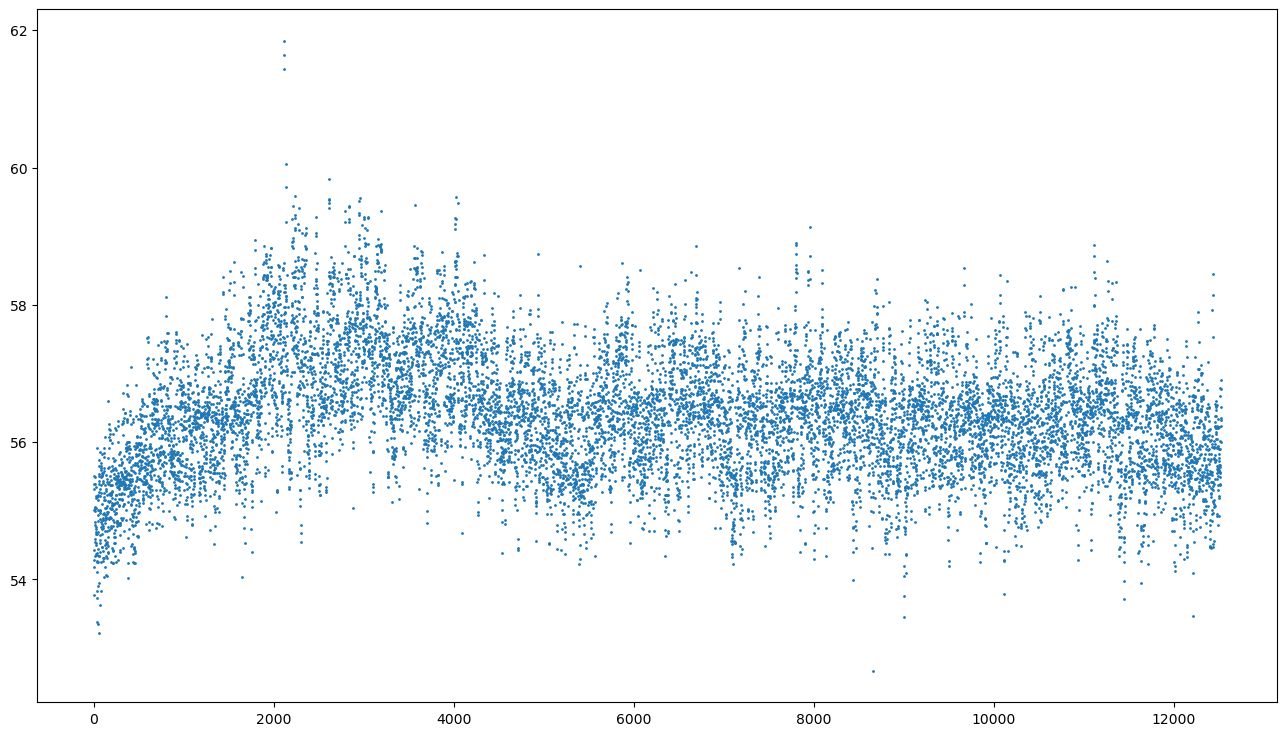

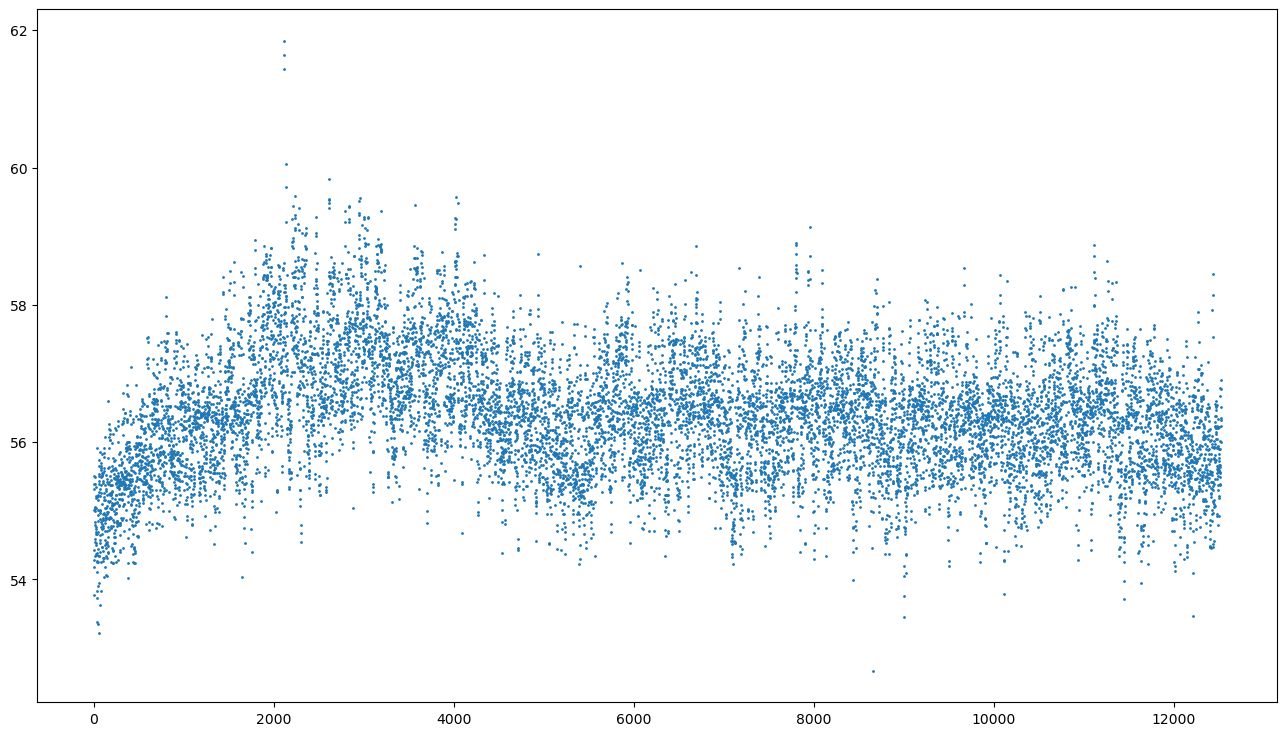

In [13]:
plt.figure(figsize = (16,9))
plt.scatter(range(len(hrs)), hrs, s = 1)
plt.show()

for index in np.where(np.array(hrs) < 40)[0]:
    hrs.pop(index)

plt.figure(figsize = (16,9))
plt.scatter(range(len(hrs)), hrs, s = 1)
plt.show()


In [15]:
def noise_psd(N, psd = lambda f: 1/(oog.sequence_manager.reference_period/120)):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1;

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f):
    return f;

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

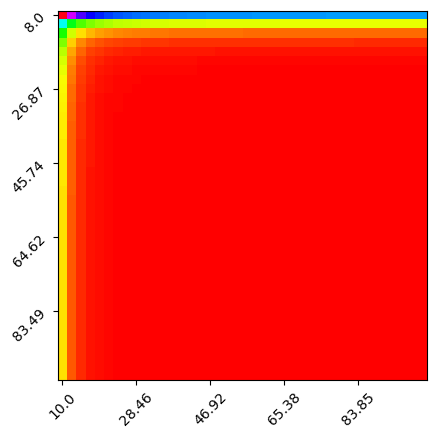

31.58974358974359
67.69230769230768


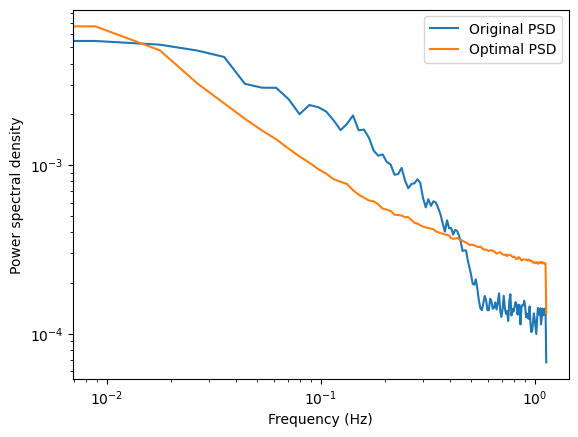

In [16]:
# Get PSD using Welch's method
from scipy.signal import welch


i_min = 8
i_max = 100
j_min = 10
j_max = 100
num = 40
i_s = np.linspace(i_min, i_max, num)
j_s = np.linspace(j_min, j_max, num)
mses = np.zeros((num, num))
f, Pxx = welch(120 / np.array(hrs), fs=1/(oog.sequence_manager.reference_period/120))
for i in range(num):
    for j in range(num):
        #plt.loglog(f, Pxx)
        #plt.xscale("log")
        #plt.xlabel("Frequency (Hz)")
        #plt.ylabel("Power spectral density")
        np.random.seed(0)
        pinknoise = np.array(pink_noise(10000)) / i_s[i]  + np.array(white_noise(10000)) / j_s[j]

        # Get PSD using Welch's method
        f, Pxx_pn = sn.welch(pinknoise, fs=1/(oog.sequence_manager.reference_period/120))

        #plt.loglog(f, Pxx)
        #plt.show()

        # GET MSE between the two
        mses[i, j] = (np.mean((Pxx[0:-1] - Pxx_pn[0:-1])**2))

plt.imshow(mses, cmap = "hsv", interpolation = "nearest")
plt.xticks(range(0,num,8), np.round(j_s[::8], 2), rotation = 45)
plt.yticks(range(0,num,8), np.round(i_s[::8], 2), rotation = 45)
plt.show()
print(i_s[np.unravel_index(np.argmin(mses), mses.shape)[0]])
print(j_s[np.unravel_index(np.argmin(mses), mses.shape)[1]])

# Plot optimal PSD
np.random.seed(100)
pinknoise = np.array(pink_noise(1000000)) / i_s[np.unravel_index(np.argmin(mses), mses.shape)[0]]  + np.array(white_noise(1000000)) / j_s[np.unravel_index(np.argmin(mses), mses.shape)[1]]
f, Pxx_pn = sn.welch(pinknoise, fs=1/(oog.sequence_manager.reference_period/120))

# Original PSD
f, Pxx = welch(120 / np.array(hrs), fs=1/(oog.sequence_manager.reference_period/120))

# Plot original PSD
plt.loglog(f, Pxx, label = "Original PSD")
plt.loglog(f, Pxx_pn, label = "Optimal PSD")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.legend()
plt.show()